# Modelling Temperature with a modified Ornstein-Uhlenbeck process

Our goal today is to fit a stochastic process so that we can model the variation as accurately as possible around our estimated temperature model taking into consideration temperature trend and seasonality.
- we're going to go through all of the Ito calculas around the stochastic dynamics of creating a modified Ornstein-Uhlenbeck process to model temperature data for the final use to price temperature and exotic options

Github: https://github.com/TheQuantPy/youtube-tutorials/blob/8e64e19629cee840928b51baf4660e5c777e87e7/2022/003%20Jul-Sep/2022-07-20%20Modifying%20the%20Ornstein-Uhlenbeck%20process%20_%20A%20practical%20application%20of%20stochastic%20calculus%20for%20Quants.ipynb

In [2]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import curve_fit
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
max_temp = pd.read_csv('maximum temp.csv')
min_temp = pd.read_csv('minimum temp.csv')
min_temp.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Minimum temperature (Degree C),Days of accumulation of minimum temperature,Quality
0,IDCJAC0011,66062,1859,1,1,14.5,NaN,Y
1,IDCJAC0011,66062,1859,1,2,15.7,1.0,Y
2,IDCJAC0011,66062,1859,1,3,15.3,1.0,Y
3,IDCJAC0011,66062,1859,1,4,17.4,1.0,Y
4,IDCJAC0011,66062,1859,1,5,16.9,1.0,Y


In [3]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in 'C:\\Users\\cozyc': ['# Implied Volatility with the Newton-Raphson Method.ipynb', '-1.14-windows.xml', '.anaconda', '.android', '.atom', '.conda', '.condarc', '.continuum', '.gitconfig', '.ipynb_checkpoints', '.ipython', '.jupyter', '.matplotlib', '.openjfx', '.spyder-py3', '.thinkorswim', '3D Objects', '456.55-desktop-win10-64bit-international-dch-whql (1).exe', 'AMDRM_Install.log', 'anaconda3', 'ansel', 'AppData', 'Application Data', 'aycd', 'candlesticksgraphs.ipynb', 'Contacts', 'Cookies', 'Creative Cloud Files', 'Creative Cloud Files pediculous@aol.com 019c2f3d76345a43554dc6b5914c5e0f6cf9ef2d8739186e8319288075a64704', 'ddd.vil', 'de.vil', 'Documents', 'Downloads', 'Downloads-20210504000348', 'Favorites', 'hddfgxc.vil', 'historicalvolatility.ipynb', 'IDCJAC0010_066062_1800_Note.txt', 'IDCJAC0011_066062_1800_Note.txt', 'iowaweather.csv', 'Jedi', 'Links', 'Local Settings', 'Log Returns and Normality.ipynb', 'maximum temp.csv', 'maximum temp.zip', 'minimum temp.csv', 'minimum

Parameters:
     a 16.8
     b 3.31e-05
 alpha 5.05
 theta 1.26


<AxesSubplot:xlabel='Date'>

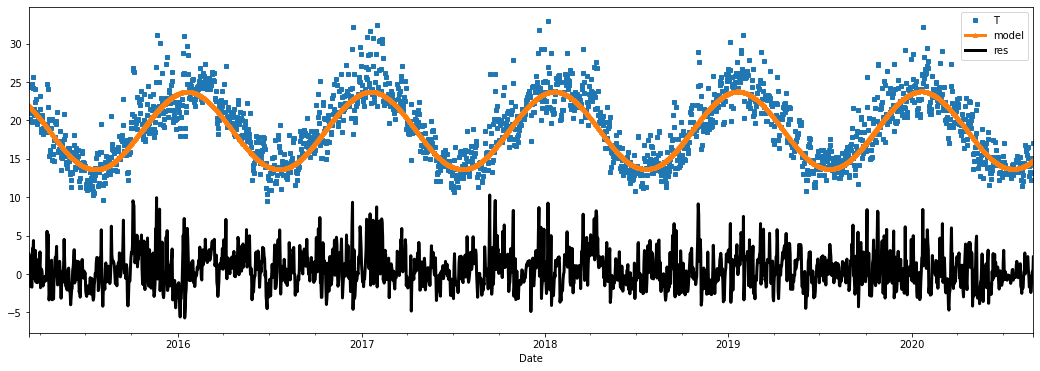

In [5]:
def datetime(row):
    return dt.datetime(row.Year,row.Month,row.Day)

max_temp['Date'] = max_temp.apply(datetime,axis=1)
min_temp['Date'] = min_temp.apply(datetime,axis=1)
max_temp.set_index('Date', inplace=True)
min_temp.set_index('Date', inplace=True)
drop_cols = [0,1,2,3,4,6,7]
max_temp.drop(max_temp.columns[drop_cols],axis=1,inplace=True)
min_temp.drop(min_temp.columns[drop_cols],axis=1,inplace=True)
max_temp.rename(columns={'Maximum temperature (Degree C)':'Tmax'}, inplace=True)
min_temp.rename(columns={'Minimum temperature (Degree C)':'Tmin'}, inplace=True)

temps = max_temp.merge(min_temp,how='inner',left_on=['Date'],right_on=['Date'])

def avg_temp(row):
    return (row.Tmax+row.Tmin)/2

temps['T'] = temps.apply(avg_temp,axis=1)

# drop na values here
temps = temps.dropna()

temp_t = temps['T'].copy(deep=True)
temp_t = temp_t.to_frame()

def model(x, params):
    a,b,a1,b1 = params
    omega = 2*np.pi/365.25 #365.25
    theta = np.arctan(a1/b1)
    alpha = np.sqrt( a1**2 + b1**2)
    print('Parameters:\n     a {0:0.3}\n     b {1:0.3}\n alpha {2:0.3}\n theta {3:0.3}'.format(a,b,alpha,theta))
    y_pred = a + b*x + alpha*np.sin(omega*x + theta)
    return y_pred

def model_fit(x, a, b, a1, b1):
    omega = 2*np.pi/365.25
    y_pred = a + b*x + a1*np.cos(omega*x) + b1*np.sin(omega*x)
    return y_pred

if isinstance(temp_t.index , pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index=temp_t.index.map(dt.datetime.toordinal)

params_all, cov = curve_fit(model_fit, xdata = temp_t.index-first_ord, ydata = temp_t['T'], method='lm')

temp_t['model'] = model(temp_t.index-first_ord, params_all)
temp_t['res'] = temp_t['T']-temp_t['model']


if not isinstance(temp_t.index , pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(dt.datetime.fromordinal)

temp_t[-2000:].plot(figsize=(18,6), style=['s','^-','k-'] , markersize=4, linewidth=3 )

# THE MATH
- The cyclical nature of the temperature time series justifies the use of a mean-reverting process in modelling it's dynamics
- We can model this to Ito process with a mean-reverting Ornstein-Uhlenbeck (OU) process

#### Academic References:

1. Temperature stochastic modeling and weather derivatives pricing: empirical study with Moroccan data, Mohammed MRAOUA & Driss BARI (2005)
2. Weather Derivatives: Pricing and Risk Management Applications, Jon Tindall (2006)
3. Weather Derivatives and the Market Price of Risk, Julius Esunge & James J. Njong (2020)

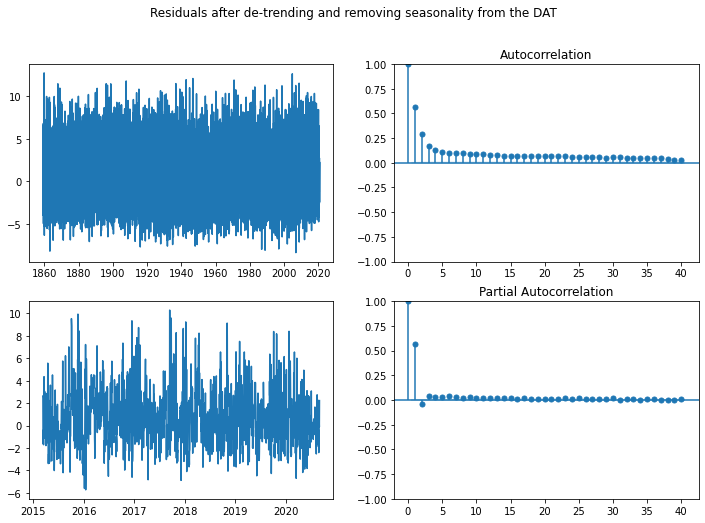

In [6]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
fig.suptitle('Residuals after de-trending and removing seasonality from the DAT')
axs[0,0].plot(temp_t['res'])
axs[1,0].plot(temp_t['res'][-2000:])
plot_acf(temp_t['res'], lags=40, ax=axs[0,1])
plot_pacf(temp_t['res'], lags=40, ax=axs[1,1])
plt.show()

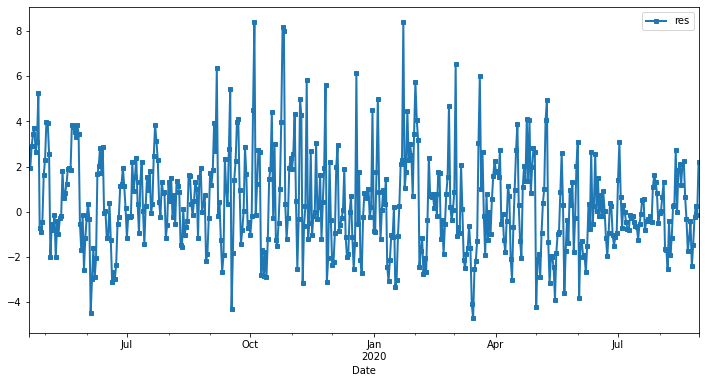

In [7]:
temp_t[['res']][-500:].plot(figsize=(12,6), style=['s-'] , markersize=4, linewidth=2 )
plt.show()

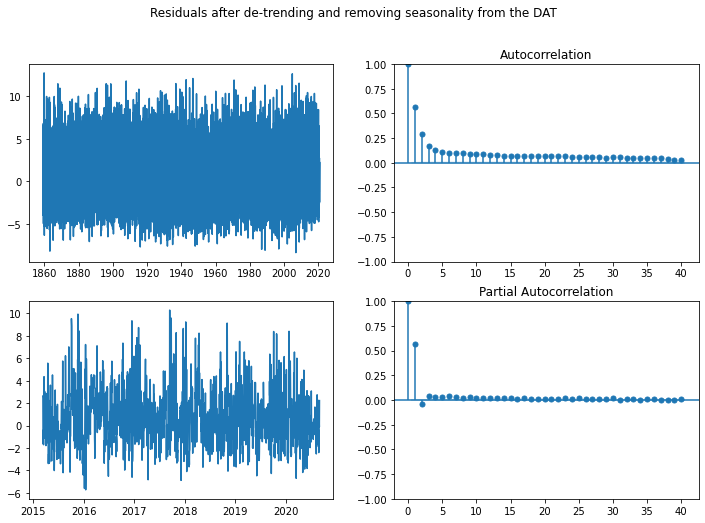

In [8]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
fig.suptitle('Residuals after de-trending and removing seasonality from the DAT')
axs[0,0].plot(temp_t['res'])
axs[1,0].plot(temp_t['res'][-2000:])
plot_acf(temp_t['res'], lags=40, ax=axs[0,1])
plot_pacf(temp_t['res'], lags=40, ax=axs[1,1])
plt.show()

In [9]:
residuals = temp_t['res']
residuals.index = pd.DatetimeIndex(residuals.index).to_period('D')

model = AutoReg(residuals, lags=1, old_names=True,trend='n')
model_fit  = model.fit()
coef = model_fit.params
res = model_fit.resid
# res.index = res.index.to_timestamp()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                    res   No. Observations:                58889
Model:                     AutoReg(1)   Log Likelihood             -122001.562
Method:               Conditional MLE   S.D. of innovations              1.921
Date:                Thu, 22 Feb 2024   AIC                         244007.123
Time:                        20:09:16   BIC                         244025.090
Sample:                    01-02-1859   HQIC                        244012.709
                         - 08-30-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
res.L1         0.5617      0.003    164.764      0.000       0.555       0.568
                                    Roots                                    
                  Real          Imaginary           M

<ipython-input-9-5b26120536bf>:4: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  model = AutoReg(residuals, lags=1, old_names=True,trend='n')


In [10]:
gamma = coef[0]
kappa = 1 - gamma

print("Kappa is estimated as: {:0.3}".format(kappa))

Kappa is estimated as: 0.438
